<a href="https://colab.research.google.com/github/guillermodelafuente/IA3_projects/blob/main/Sea_Ice_Extent_Guillermo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.


### 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  

In [52]:
#your solution here
import numpy as np
import pandas as pd
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')

#### Read data

In [2]:
from google.colab import files
df = files.upload()

Saving SeaIce.txt to SeaIce.txt


In [14]:
ls

sample_data/  SeaIce.txt


In [138]:
df = pd.read_csv("SeaIce.txt", delim_whitespace=True)
df

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92
...,...,...,...,...,...,...
419,2009,12,Goddard,N,12.51,10.25
420,2010,12,Goddard,N,12.02,10.08
421,2011,12,Goddard,N,12.40,10.28
422,2012,12,Goddard,N,12.20,10.11


#### Data cleaning

In [139]:
df = df[(df['extent'] >= 0) | (df['extent'].isnull())]
#df.sort_values(by='extent')
df.sort_values(by='area')

,year,mo,data_type,region,extent,area
315,2012,9,Goddard,N,3.63,2.15
280,2012,8,Goddard,N,4.71,2.56
310,2007,9,Goddard,N,4.30,2.78
314,2011,9,Goddard,N,4.63,2.94
311,2008,9,Goddard,N,4.73,2.99
...,...,...,...,...,...,...
50,1993,2,Goddard,N,15.73,13.54
94,2001,3,Goddard,N,15.61,13.57
55,1998,2,Goddard,N,15.77,13.70
86,1993,3,Goddard,N,15.88,13.71


#### Exporatory data Analysis

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       424 non-null    int64  
 1   mo         424 non-null    int64  
 2   data_type  424 non-null    object 
 3   region     424 non-null    object 
 4   extent     424 non-null    float64
 5   area       424 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 20.0+ KB


In [47]:
df.describe()

,year,mo,extent,area
count,422.000000,422.000000,422.000000,422.000000
mean,1996.040284,6.500000,11.777583,9.287796
std,10.222038,3.461872,3.120722,3.180044
min,1978.000000,1.000000,3.630000,2.150000
25%,1987.000000,3.250000,9.360000,6.382500
50%,1996.000000,6.500000,12.395000,9.990000
75%,2005.000000,9.750000,14.560000,12.227500
max,2014.000000,12.000000,16.450000,13.840000


data_type and region are categorical features 

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

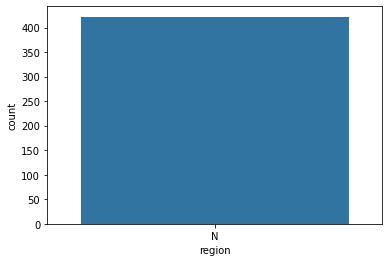

In [54]:
x1 = sns.countplot(df['region'])
plt.show(x1)

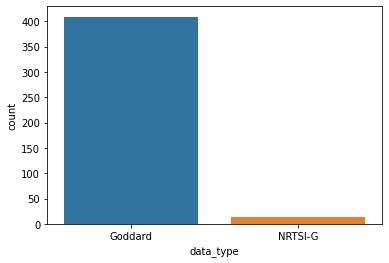

In [53]:
x = sns.countplot(df['data_type'])
plt.show(x)

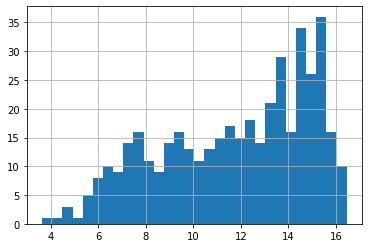

In [82]:
e=df['extent']
e.hist(density=0, histtype='stepfilled', bins=30)

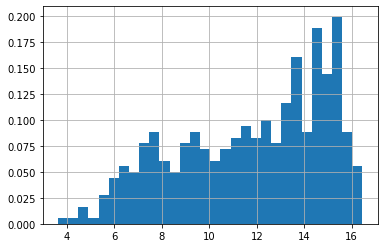

In [81]:
e.hist(density=1, histtype='stepfilled', bins=30)

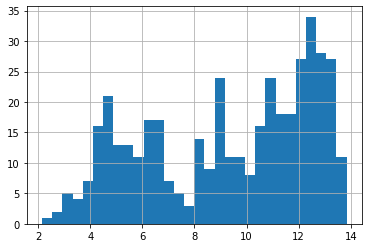

In [74]:
a=df['area']
a.hist(density=0, histtype='stepfilled', bins=30) 

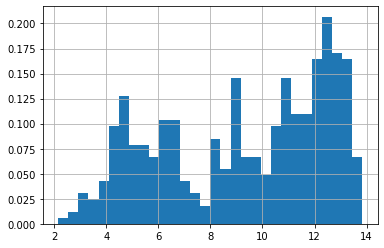

In [83]:
a.hist(density=1, histtype='stepfilled', bins=30) # density = 1 for normalized histogram

#### Outliers

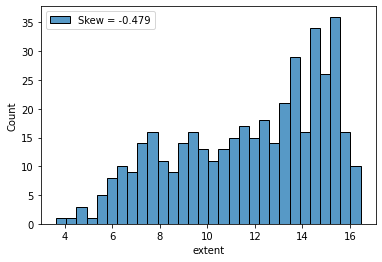

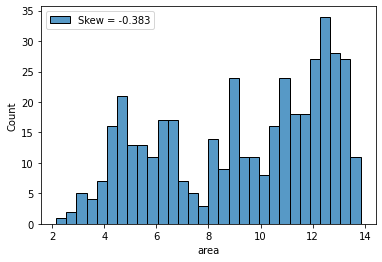

In [63]:
# Skew - asymmetry
for feat in features:
    skew = df[feat].skew()
    sns.histplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [61]:
features = df.columns[-2:]
features

Index(['extent', 'area'], dtype='object')

Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

In [70]:
# Detect observations with more than one outlier
# Tukey Method
from collections import Counter

def outlier_hunt(dataframe):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in dataframe.columns.tolist():
        
        # 1st quartile (25%)
        Q1 = np.percentile(dataframe[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(dataframe[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

In [72]:
print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))   

The dataset contains 0 observations with more than 2 outliers


### 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

In [ ]:
#df_sorted = df.sort_values(['year', 'mo'])
#df_sorted.head(20)

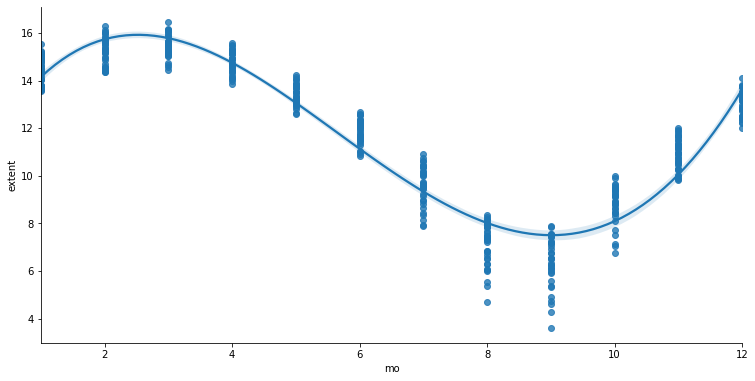

In [106]:
g = sns.lmplot(x="mo", y="extent", data=df, order=4, height=5.2, aspect=2)

In [110]:
df.groupby('mo').mean()

,year,extent,area
mo,,,
1,1996.742857,14.479429,12.118571
2,1996.500000,15.298889,12.920833
3,1996.000000,15.491714,13.076857
4,1996.000000,14.766000,12.426286
5,1996.000000,13.396000,11.013714
6,1996.000000,11.860000,9.015143
7,1996.000000,9.601143,6.237714
8,1996.000000,7.122286,4.530571
9,1996.000000,6.404857,4.246286


In [114]:
SIE_mean = df.groupby('mo').mean()
del SIE_mean['year']
SIE_mean

,extent,area
mo,,
1,14.479429,12.118571
2,15.298889,12.920833
3,15.491714,13.076857
4,14.766000,12.426286
5,13.396000,11.013714
6,11.860000,9.015143
7,9.601143,6.237714
8,7.122286,4.530571
9,6.404857,4.246286


In [212]:
SIE_mean['extent'].iloc[0]

14.479428571428572

In [116]:
SIE_var = df.groupby('mo').var()
del SIE_var['year']
SIE_var

,extent,area
mo,,
1,0.304906,0.187330
2,0.295804,0.193191
3,0.237209,0.140269
4,0.215378,0.109648
5,0.189901,0.097942
6,0.247918,0.255561
7,0.679175,0.393130
8,0.824577,0.515723
9,1.143902,0.622165


Normalize the SIE data: subtract the monthly mean and then convert to percent 


difference by dividing by the monthly mean and then multiplying by 100. Use the normalized SIE for the rest of the exercise.

In [147]:
features

Index(['extent', 'area'], dtype='object')

In [150]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [219]:
df_norm = df.copy()
df_norm.info

<bound method DataFrame.info of      year  mo data_type region  extent   area
0    1979   1   Goddard      N   15.54  12.33
1    1980   1   Goddard      N   14.96  11.85
2    1981   1   Goddard      N   15.03  11.82
3    1982   1   Goddard      N   15.26  12.11
4    1983   1   Goddard      N   15.10  11.92
..    ...  ..       ...    ...     ...    ...
419  2009  12   Goddard      N   12.51  10.25
420  2010  12   Goddard      N   12.02  10.08
421  2011  12   Goddard      N   12.40  10.28
422  2012  12   Goddard      N   12.20  10.11
423  2013  12   NRTSI-G      N   12.38  10.48

[422 rows x 6 columns]>

In [220]:
for month in range(1,13):
    df_norm['extent'][(df_norm['mo']==month)] = df_norm['extent'][(df_norm['mo']==month)]/SIE_mean['extent'].iloc[month-1]*100
    df_norm['area'][(df_norm['mo']==month)] = df_norm['area'][(df_norm['mo']==month)]/SIE_mean['area'].iloc[month-1]*100

In [221]:
df_norm[(df_norm['mo']==12)]

,year,mo,data_type,region,extent,area
388,1978,12,Goddard,N,108.121117,100.879290
389,1979,12,Goddard,N,103.679881,98.090001
390,1980,12,Goddard,N,105.058196,99.577622
391,1981,12,Goddard,N,105.211342,97.346191
392,1982,12,Goddard,N,105.900499,100.507385
393,1983,12,Goddard,N,102.914151,98.182977
394,1984,12,Goddard,N,100.923252,94.742854
395,1985,12,Goddard,N,100.999825,94.370949
396,1986,12,Goddard,N,102.607859,97.253214
398,1988,12,Goddard,N,105.517634,111.013707


In [179]:
df[(df['mo']==2)]

,year,mo,data_type,region,extent,area
36,1979,2,Goddard,N,16.31,13.11
37,1980,2,Goddard,N,15.98,12.82
38,1981,2,Goddard,N,15.65,12.45
39,1982,2,Goddard,N,16.06,12.79
40,1983,2,Goddard,N,16.02,12.86
41,1984,2,Goddard,N,15.32,12.17
42,1985,2,Goddard,N,15.67,12.39
43,1986,2,Goddard,N,15.89,12.53
44,1987,2,Goddard,N,16.11,12.93
45,1988,2,Goddard,N,15.61,13.49


Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

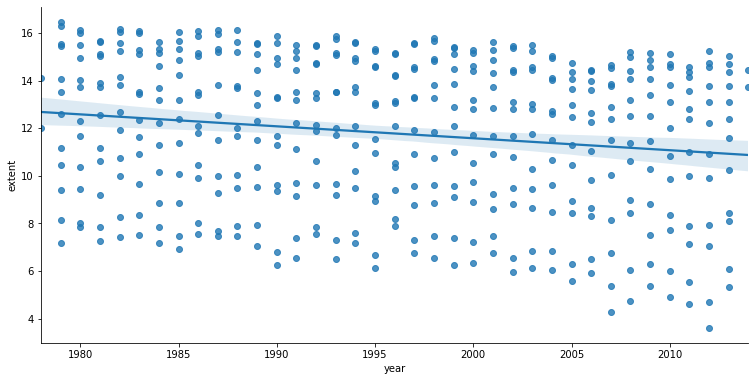

In [267]:
# Considering all months ** dataframe not normalized **
g = sns.lmplot(x="year", y="extent", data=df, order=1, height=5.2, aspect=2)

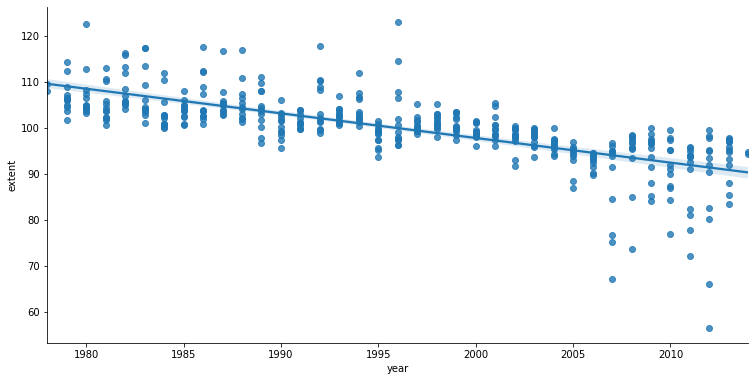

In [223]:
# Considering all months
g = sns.lmplot(x="year", y="extent", data=df_norm, order=1, height=5.2, aspect=2)

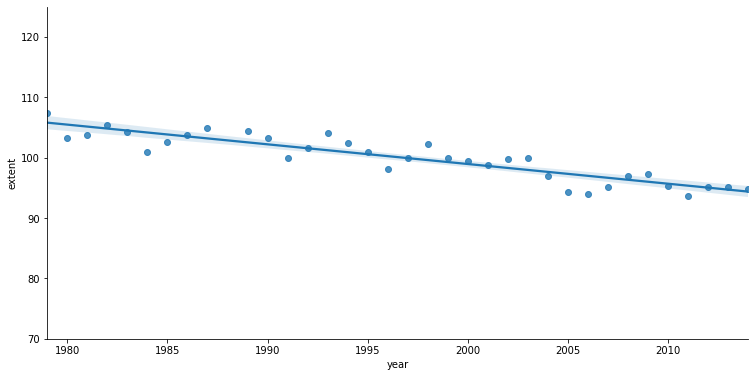

In [235]:
# Considering January (Month ==1)
g = sns.lmplot(x="year", y="extent", data=df_norm[(df_norm['mo']==1)], order=1, height=5.2, aspect=2)
g.set(ylim=(70, 125))
plt.show()

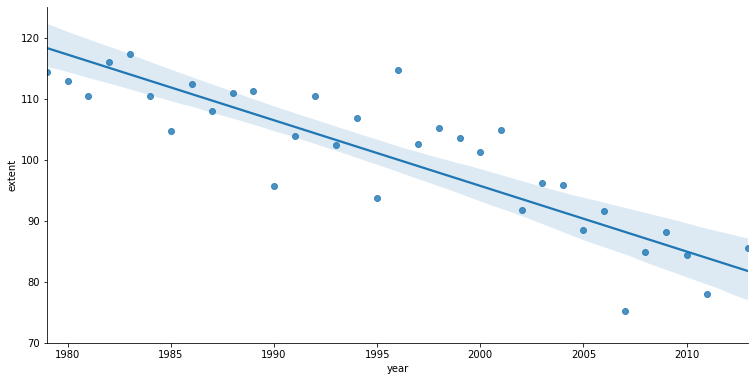

In [236]:
# Considering August (Month ==8)
g = sns.lmplot(x="year", y="extent", data=df_norm[(df_norm['mo']==8)], order=1, height=5.2, aspect=2)
g.set(ylim=(70, 125))
plt.show()

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

In [ ]:
#yes 
#Pearson correlation is -0.71. it means negative correltion btw temporal trend and SIE is found on the dataset
# considering the negative correlation and SIE mean = 11 and SIE std =3 
    # By Using Pvalue we calculate the probability that we get at some point a SIE value mean of 1 which is almost no Ice anymore...

Pearson's correlation coefficient $\rho$ is a measure of the strength of the linear association between two variables. It also takes into account the standard deviation $\sigma$ to measure the relationship among variables:
 
$$ \rho = \frac{1}{n} \sum p_i = \frac{1}{n} \sum  \frac{(x_i - \mu_X)}{\sigma_X} \frac{(y_i - \mu_Y)}{\sigma_Y}  $$

Or we can rewrite $\rho$ by factoring out $\sigma_X$ and $\sigma_Y$:

$$ \rho = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}$$

When $\rho = 0$, we cannot say that there is no relationship between the variables!

Pearson's coefficient only measures **linear** correlations!

In [252]:
X=df_norm['year']
Y=df_norm['extent']

In [255]:
def Cov(X, Y):
    def _get_dvis(V):
        return [v - np.mean(V) for v in V]
    dxis = _get_dvis(X)
    dyis = _get_dvis(Y)
    return np.sum([x * y for x, y in zip(dxis, dyis)])/len(X)

print("Cov(X, X) = %.2f" % Cov(X, X))
print("Var(X) = %.2f" % np.var(X))

print( "Cov(X, Y) = %.2f" % Cov(X, Y))

Cov(X, X) = 104.24
Var(X) = 104.24
Cov(X, Y) = -55.81


In [256]:
#Pearson correlation
def Corr(X, Y):
    assert len(X) == len(Y)
    return Cov(X, Y) / np.prod([np.std(V) for V in [X, Y]])

In [257]:
print("Corr(X, Y) = %.5f" % Corr(X,Y))

Corr(X, Y) = -0.71578


In [ ]:
#https://towardsdatascience.com/p-value-basics-with-python-code-ae5316197c52

In [258]:
def pvalue_101(mu, sigma, samp_size, samp_mean=0, deltam=0):
    np.random.seed(1234)
    s1 = np.random.normal(mu, sigma, samp_size)
    if samp_mean > 0:
        print(len(s1[s1>samp_mean]))
        outliers = float(len(s1[s1>samp_mean])*100)/float(len(s1))
        print('Percentage of numbers larger than {} is {}%'.format(samp_mean, outliers))
    if deltam == 0:
        deltam = abs(mu-samp_mean)
    if deltam > 0 :
        outliers = (float(len(s1[s1>(mu+deltam)]))
                    +float(len(s1[s1<(mu-deltam)])))*100.0/float(len(s1))
        print('Percentage of numbers further than the population mean of {} by +/-{} is {}%'.format(mu, deltam, outliers))

    fig, ax = plt.subplots(figsize=(8,8))
    fig.suptitle('Normal Distribution: population_mean={}'.format(mu) )
    plt.hist(s1)
    plt.axvline(x=mu+deltam, color='red')
    plt.axvline(x=mu-deltam, color='green')
    plt.show()

In [263]:
mu = df['extent'].mean()
sigma = df['extent'].std()

print(mu)
print(sigma)

11.777582938388628
3.1207220731668


9996
Percentage of numbers larger than 1 is 99.96%
Percentage of numbers further than the population mean of 11.777582938388628 by +/-10.777582938388628 is 0.04%


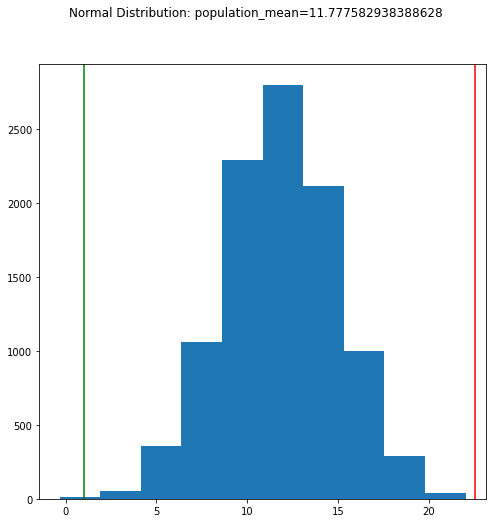

In [269]:
pvalue_101(mu, sigma, 10000, 1) 

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

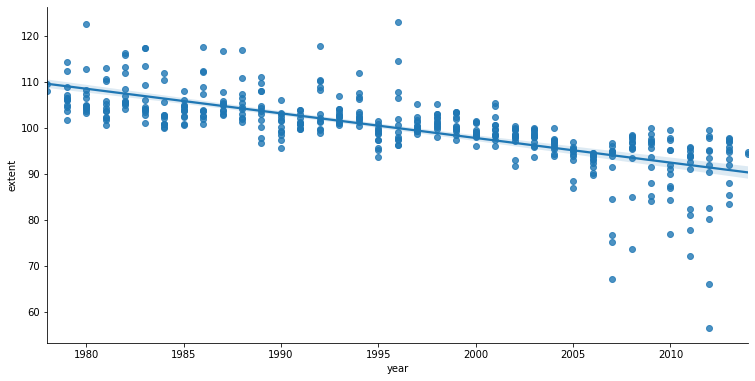

In [277]:
# Considering all months
g = sns.lmplot(x="year", y="extent", data=df_norm, order=1, height=5.2, aspect=2)

In [273]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=False) 
clf.fit ([[0, 1], [1, 1], [2, 1]], [0, 1, 2])  # Perform the fitting
clf.coef_

array([1.00000000e+00, 7.94894028e-18])

In [276]:
from sklearn.model_selection import train_test_split
X=pd.DataFrame(df_norm['year'])
Y=df_norm['extent']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print('Train and test sizes', X_train.shape, X_test.shape)
SIE_reg = LinearRegression()
SIE_reg.fit(X_train, y_train) 
print('Coeff and intercept:', SIE_reg.coef_, SIE_reg.intercept_)
# Score is R^2: Best possible score is 1.0, lower values are worse.
print('Score:', SIE_reg.score(X_test, y_test)) 
print('Training MSE: ', np.mean((SIE_reg.predict(X_train) - y_train)**2))
print('Test MSE: ', np.mean((SIE_reg.predict(X_test) - y_test)**2))

Train and test sizes (295, 1) (127, 1)
Coeff and intercept: [-0.52405291] 1146.1746041982922
Score: 0.5170167022136911
Training MSE:  27.67322297877544
Test MSE:  30.33516162218946


Text(0, 0.5, 'Target')

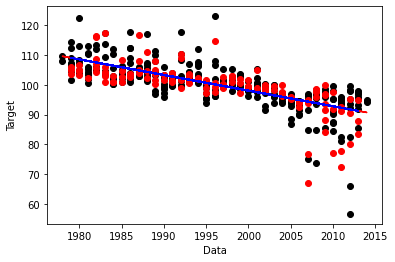

In [282]:
# Visualize the linear model prediction
plt.scatter(X_train, y_train, color='black')
plt.plot(X_train, SIE_reg.predict(X_train), color='red')
plt.xlabel('Data')
plt.ylabel('Target')

plt.scatter(X_test, y_test, color='red'),
plt.plot(X_test, SIE_reg.predict(X_test), color='blue')
plt.xlabel('Data')
plt.ylabel('Target')

### 4. Estimate the sea ice extent for January 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

In [ ]:
#obvio, check below

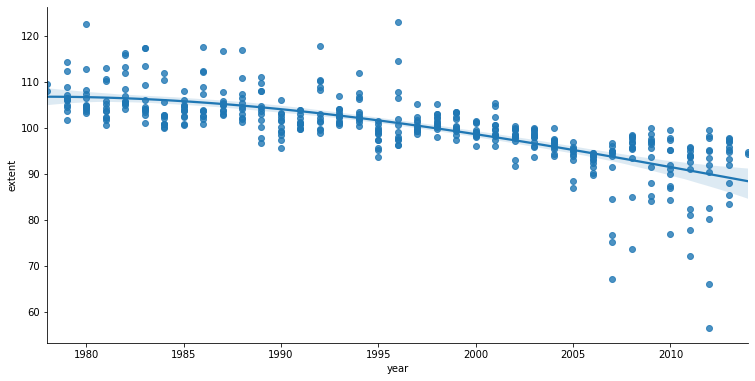

In [286]:
# Considering all months
g = sns.lmplot(x="year", y="extent", data=df_norm, order=3, height=5.2, aspect=2)

In [289]:
m=SIE_reg.coef_
n=SIE_reg.intercept_
x=2025
y = m*x+n
print('the normalized value of SIE for 2025 is:', y)

the normalized value of SIE for 2025 is: [84.96745981]
